# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [4]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

import unicodedata
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import urllib
import requests
from nltk.corpus import stopwords 
import string 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, confusion_matrix
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier,\
            ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB

In [5]:
pd.set_option('display.max_colwidth', 1000)
path = "Data/train_tweets.csv"
tweetData = pd.read_csv(path, sep=',', encoding='UTF-8')
tweetData.drop(labels= 'id', axis=1, inplace= True)
tweetData.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


# Pre-processing

In [6]:
newStopWords = ['thi','amp','if','sjw','user','co']
stop_words = stopwords.words(fileids='english')
stop_words.extend(newStopWords)

In [7]:
def remove_pattern(input_txt, pattern):
    txt = re.sub(pattern, " ", input_txt)
    return txt

In [8]:
def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], r"@[\w]*")
    dataframe['cleaned'] = dataframe['cleaned'].str.replace("[^a-zA-Z#]", " ")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe

In [9]:
tweetDataCleaned = preprocess(tweetData)
tweetDataCleaned.head()

,label,tweet,cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love take time ur
4,0,factsguide: society now #motivation,factsguide society motivation


# up-sample

In [10]:
tweet_majority = tweetDataCleaned[tweetDataCleaned["label"]==0]
tweet_minority = tweetDataCleaned[tweetDataCleaned["label"]==1]

tweetDataCleaned_minority_upsampled = resample(tweet_minority,
                                               replace=True,     # sample with replacement
                                               n_samples=29720,    # to match majority class
                                               random_state=0) # reproducible results
tweetDataCleaned_upsampled = pd.concat([tweet_majority, tweetDataCleaned_minority_upsampled])

tweetDataCleaned_upsampled.label.value_counts()

1    29720
0    29720
Name: label, dtype: int64

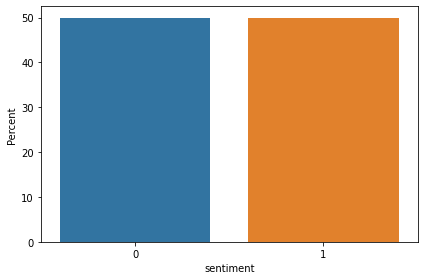

In [11]:
ax = sns.barplot(x='label',y='label', estimator=lambda x: len(x) / len(tweetDataCleaned_upsampled) * 100,\
                 data=tweetDataCleaned_upsampled)
ax.set(ylabel='Percent', xlabel='sentiment')
fig = ax.get_figure()
fig.savefig("cls_up.png")

## TF-IDF

In [12]:
tweetDataCleaned_upsampled = tweetDataCleaned_upsampled.sample(frac=1)

In [13]:
train = tweetDataCleaned_upsampled.iloc[:29720,0]
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')
tfidf_matrix=tfidf.fit_transform(tweetDataCleaned_upsampled['cleaned'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())

train_tfidf_matrix = tfidf_matrix[:29720]
train_tfidf_matrix.todense()
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train,test_size=0.3,random_state=17)

## Logistic regression

In [14]:
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')
Log_Reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
Log_Reg_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(Log_Reg_tfidf))
print('Model - '+str(Log_Reg))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4374
           1       0.92      0.85      0.89      4542

    accuracy                           0.89      8916
   macro avg       0.89      0.89      0.89      8916
weighted avg       0.89      0.89      0.89      8916

accuracy_score:0.8872812920592194
Model - LogisticRegression(random_state=0)
Confusion Matrix:


array([[4032,  342],
       [ 663, 3879]])

### Decision Tree Classifier

In [15]:
dec_tree = DecisionTreeClassifier(class_weight="balanced", random_state=0,criterion="entropy", max_depth=4)
dec_tree.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = dec_tree.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
dec_tree_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(dec_tree_tfidf))
print('Model - '+str(dec_tree))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.53      0.99      0.69      4374
           1       0.95      0.15      0.26      4542

    accuracy                           0.56      8916
   macro avg       0.74      0.57      0.48      8916
weighted avg       0.75      0.56      0.47      8916

accuracy_score:0.5638178555406012
Model - DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=0)
Confusion Matrix:


array([[4340,   34],
       [3855,  687]])

### RandomForestClassifier

In [16]:
ran_forest = RandomForestClassifier(class_weight="balanced", random_state=0,criterion="entropy", 
                               max_depth=5, max_samples=200)
ran_forest.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = ran_forest.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.45
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
ran_forest_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(ran_forest_tfidf))
print('Model - '+str(ran_forest))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.93      0.18      0.31      4374
           1       0.56      0.99      0.71      4542

    accuracy                           0.59      8916
   macro avg       0.74      0.59      0.51      8916
weighted avg       0.74      0.59      0.51      8916

accuracy_score:0.5928667563930013
Model - RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_samples=200, random_state=0)
Confusion Matrix:


array([[ 808, 3566],
       [  64, 4478]])

### MultinomialNB

In [17]:
mnb = MultinomialNB(alpha=1.0, fit_prior=False)
mnb.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = mnb.predict_proba(x_valid_tfidf)

prediction_int = prediction_tfidf[:,1]>=0.55
prediction_int = prediction_int.astype(np.int)
prediction_int

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
mnb_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(mnb_tfidf))
print('Model - '+str(mnb))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4374
           1       0.90      0.83      0.87      4542

    accuracy                           0.87      8916
   macro avg       0.87      0.87      0.87      8916
weighted avg       0.87      0.87      0.87      8916

accuracy_score:0.8689995513683266
Model - MultinomialNB(fit_prior=False)
Confusion Matrix:


array([[3975,  399],
       [ 769, 3773]])

## Ensemble

In [18]:
model = VotingClassifier(estimators=[('lr',Log_Reg),('mnb',mnb)], voting='soft')
model.fit(x_train_tfidf,y_train_tfidf)
prediction_int = model.predict(x_valid_tfidf)

print(classification_report(y_valid_tfidf, prediction_int))
print("===="*20)
model_tfidf = accuracy_score(y_valid_tfidf, prediction_int)
print("accuracy_score:"+str(model_tfidf))
print('Model - '+str(model))
print("===="*20)
print("Confusion Matrix:")
confusion_matrix(y_valid_tfidf, prediction_int, labels = [0,1])

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4374
           1       0.90      0.87      0.89      4542

    accuracy                           0.89      8916
   macro avg       0.89      0.89      0.89      8916
weighted avg       0.89      0.89      0.89      8916

accuracy_score:0.8854867653656349
Model - VotingClassifier(estimators=[('lr', LogisticRegression(random_state=0)),
                             ('mnb', MultinomialNB(fit_prior=False))],
                 voting='soft')
Confusion Matrix:


array([[3931,  443],
       [ 578, 3964]])

# Prediction of new data

In [19]:
testData = pd.read_csv("Data/test_tweets.csv")
testDataCleaned = preprocess(testData)
testDataCleaned.head()

,tweet,cleaned
0,"@TheQuint @shadabmoizee All #CAA_NRC_NPR Protests by Muslims incited by Congress &amp; Communists for allowing illegal immigrants from Pakistan, Bangladesh &amp; Myanmar into india is wrong since the #CitizenshipAmendmentAct was passed both in RAJYA SABHA &amp; LOK SABHA. https://t.co/6LKhvw27yk",caa nrc npr protest muslim incited congress communist allowing illegal immigrant pakistan bangladesh myanmar india wrong since citizenshipamendmentact passed rajya sabha lok sabha
1,"@jijoy_matt @sumanthraman #ISLAMOPHOBIA FACT:\r\n\r\nNon-Muslims must be educated on ""ISLAMIC SHARIA LAW &amp; DEMOGRAPHIC JIHAD"" to know the Anti-Muslim Law in #CitizenshipAmendmentAct.\r\n\r\nSEPARATE RELIGION &amp; STATE FOR SECULAR UNIFORM CIVIL CODE.\r\n\r\ncc: @rashtrapatibhvn @VPSecretariat @PMOIndia @HMOIndia @amitmalviya https://t.co/HWoyE3obc2",islamophobia fact non muslim must educated islamic sharia law demographic jihad know anti muslim law citizenshipamendmentact separate religion state secular uniform civil code cc
2,"@BernieSanders @POTUS @realDonaldTrump @OIC_OCI @PeteButtigieg @ewarren @UKParliament @BorisJohnson @KremlinRussia_E @JustinTrudeau @georgesoros @OpenSociety @USCIRF must see india's Anti-Muslim #CitizenshipAmendmentAct while keeping in mind ""HUMANITY'S GOLDEN RULE OF TREATING OTHERS LIKE YOU ARE TREATED"" \r\n\r\nISLAMIC SHARIA ILL TREATS NON-MUSLIMS AS KAFIRS\r\nhttps://t.co/jU7S3f71Pj\r\n\r\n @HMOIndia @AmitShah @DrSJaishankar @MEAIndia @MEAIndia https://t.co/lQ2IWm83n2",must see india anti muslim citizenshipamendmentact keeping mind humanity golden rule treating others like treated islamic sharia ill treat non muslim kafir
3,Three\r\n\r\nA lone flag flutters\r\nIn a city charred by winds\r\nThus nation prevails\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram #poetry… https://t.co/2A0b30YjCc,three lone flag flutter city charred wind thus nation prevails delhi citizenshipamendmentact delhiprotest delhiviolence haiku travelhaiku haikugram micropoetry writersofinstagram poetry
4,Five\r\n\r\nShivering squirrels\r\nWithin withering tree trunks\r\nDo not make a noise\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence #resist\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram… https://t.co/IChVLOFHdv,five shivering squirrel within withering tree trunk make noise delhi citizenshipamendmentact delhiprotest delhiviolence resist haiku travelhaiku haikugram micropoetry writersofinstagram


In [32]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')
tfidf_matrix=tfidf.fit_transform(testDataCleaned['cleaned'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())

prediction_int = model.predict(tfidf_matrix)
model.get_params(deep = False)


{'estimators': [('lr', LogisticRegression(random_state=0)),
  ('mnb', MultinomialNB(fit_prior=False))],
 'flatten_transform': True,
 'n_jobs': None,
 'verbose': False,
 'voting': 'soft',
 'weights': None}

In [28]:
#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission_upsample = pd.DataFrame({'tweet':testDataCleaned['tweet'],'Sentiment':prediction_int})
submission_upsample.to_csv('submission_upsample.csv', index=False)
#print(submission_upsample.shape)
submission_upsample.head()

,tweet,Sentiment
0,"@TheQuint @shadabmoizee All #CAA_NRC_NPR Protests by Muslims incited by Congress &amp; Communists for allowing illegal immigrants from Pakistan, Bangladesh &amp; Myanmar into india is wrong since the #CitizenshipAmendmentAct was passed both in RAJYA SABHA &amp; LOK SABHA. https://t.co/6LKhvw27yk",1
1,"@jijoy_matt @sumanthraman #ISLAMOPHOBIA FACT:\r\n\r\nNon-Muslims must be educated on ""ISLAMIC SHARIA LAW &amp; DEMOGRAPHIC JIHAD"" to know the Anti-Muslim Law in #CitizenshipAmendmentAct.\r\n\r\nSEPARATE RELIGION &amp; STATE FOR SECULAR UNIFORM CIVIL CODE.\r\n\r\ncc: @rashtrapatibhvn @VPSecretariat @PMOIndia @HMOIndia @amitmalviya https://t.co/HWoyE3obc2",0
2,"@BernieSanders @POTUS @realDonaldTrump @OIC_OCI @PeteButtigieg @ewarren @UKParliament @BorisJohnson @KremlinRussia_E @JustinTrudeau @georgesoros @OpenSociety @USCIRF must see india's Anti-Muslim #CitizenshipAmendmentAct while keeping in mind ""HUMANITY'S GOLDEN RULE OF TREATING OTHERS LIKE YOU ARE TREATED"" \r\n\r\nISLAMIC SHARIA ILL TREATS NON-MUSLIMS AS KAFIRS\r\nhttps://t.co/jU7S3f71Pj\r\n\r\n @HMOIndia @AmitShah @DrSJaishankar @MEAIndia @MEAIndia https://t.co/lQ2IWm83n2",1
3,Three\r\n\r\nA lone flag flutters\r\nIn a city charred by winds\r\nThus nation prevails\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram #poetry… https://t.co/2A0b30YjCc,1
4,Five\r\n\r\nShivering squirrels\r\nWithin withering tree trunks\r\nDo not make a noise\r\n\r\n#delhi #citizenshipamendmentact\r\n#delhiprotest #delhiviolence #resist\r\n\r\n#haiku #travelhaiku #haikugram #micropoetry #writersofinstagram… https://t.co/IChVLOFHdv,0


In [26]:
len(prediction_int[prediction_int==0])

2669